# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Data loading and merging

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head(20)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [5]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## profile :

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
profile.duplicated().sum()

0

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


## Trascript: 

In [11]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id') if x.get('offer id')!= None else x.get('offer_id'))

transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount') )

transcript = transcript.drop(columns='value')

In [13]:
transcript.amount

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
306529    1.59
306530    9.53
306531    3.61
306532    3.53
306533    4.05
Name: amount, Length: 306534, dtype: float64

In [14]:
transcript.head(10)

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
6,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [15]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   time      306534 non-null  int64  
 3   offer_id  167581 non-null  object 
 4   amount    138953 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 11.7+ MB


In [16]:
transcript.describe()

,time,amount
count,306534.000000,138953.000000
mean,366.382940,12.777356
std,200.326314,30.250529
min,0.000000,0.050000
25%,186.000000,2.780000
50%,408.000000,8.890000
75%,528.000000,18.070000
max,714.000000,1062.280000


In [17]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [18]:
transcript.groupby('event').count()

,person,time,offer_id,amount
event,,,,
offer completed,33579,33579,33579,0
offer received,76277,76277,76277,0
offer viewed,57725,57725,57725,0
transaction,138953,138953,0,138953


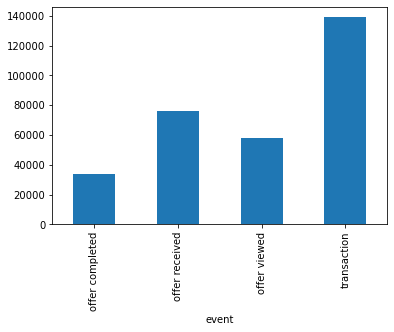

In [19]:
transcript.groupby('event')['event'].count().plot(kind='bar');

In [20]:
transcript = transcript.rename(columns={'person':'customer_id'})
profile = profile.rename(columns = {'id':'customer_id'})

In [21]:
df = pd.merge(transcript, profile, on = 'customer_id', how='inner')

In [22]:
df.head()

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,None,19.89,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,None,17.78,F,75,20170509,100000.0


In [23]:
portfolio = portfolio.rename(columns = {'id':'offer_id'})
df = pd.merge(df, portfolio, on = 'offer_id')


In [24]:
df.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'channels', 'difficulty',
       'duration', 'offer_type'],
      dtype='object')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_id       167581 non-null  object 
 1   event             167581 non-null  object 
 2   time              167581 non-null  int64  
 3   offer_id          167581 non-null  object 
 4   amount            0 non-null       float64
 5   gender            148805 non-null  object 
 6   age               167581 non-null  int64  
 7   became_member_on  167581 non-null  int64  
 8   income            148805 non-null  float64
 9   reward            167581 non-null  int64  
 10  channels          167581 non-null  object 
 11  difficulty        167581 non-null  int64  
 12  duration          167581 non-null  int64  
 13  offer_type        167581 non-null  object 
dtypes: float64(2), int64(6), object(6)
memory usage: 19.2+ MB


In [26]:
df.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [27]:
offer_dic = pd.Series(df['offer_id'].sort_values().unique()).to_dict()
offer_dic = dict([(value, key) for key, value in offer_dic.items()]) 
offer_dic

{'0b1e1539f2cc45b7b9fa7c272da2e1d7': 0,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 1,
 '2906b810c7d4411798c6938adc9daaa5': 2,
 '3f207df678b143eea3cee63160fa8bed': 3,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 4,
 '5a8bc65990b245e5a138643cd4eb9837': 5,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 6,
 'ae264e3637204a6fb9bb56bc8210ddfd': 7,
 'f19421c1d4aa40978ebb69ca19b0e20d': 8,
 'fafdcd668e3743c1bb461111dcafc2a4': 9}

In [28]:
df.head()

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5,"[web, email, mobile]",5,7,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5,"[web, email, mobile]",5,7,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5,"[web, email, mobile]",5,7,bogo
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,20180426,70000.0,5,"[web, email, mobile]",5,7,bogo
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,20180426,70000.0,5,"[web, email, mobile]",5,7,bogo


In [29]:
df.to_csv('data/clean_data.csv', index=False)

# Exploratory Data Analysis

In [30]:
data = pd.read_csv('data/clean_data.csv')

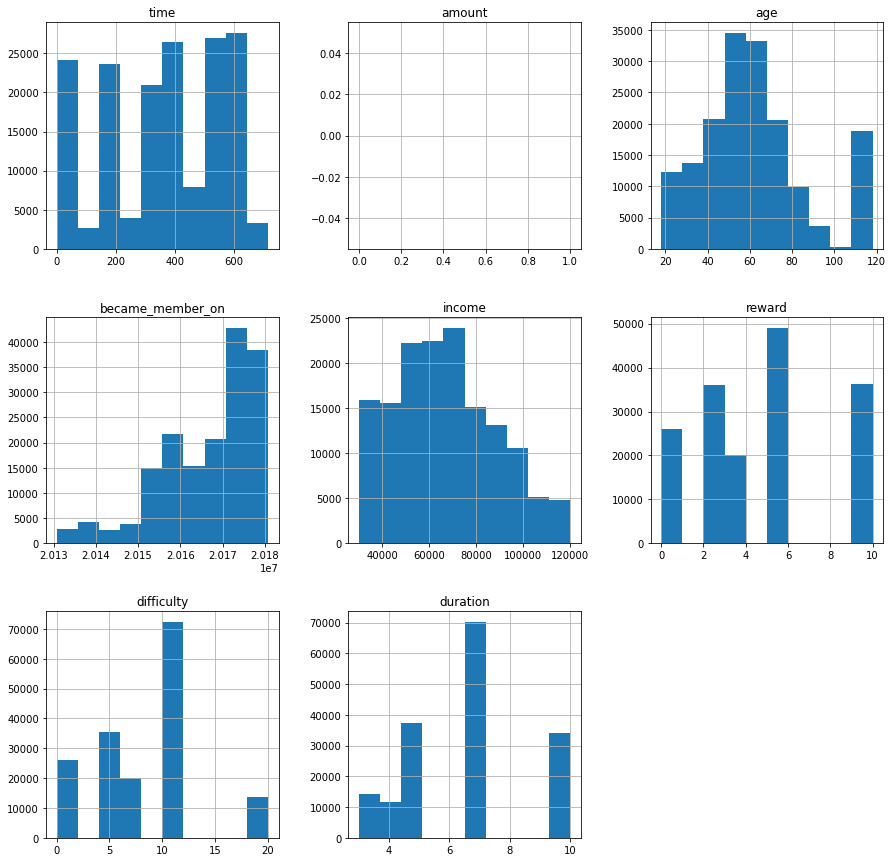

In [31]:
data.hist(figsize=(15,15));

In [32]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167581 entries, 0 to 167580
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_id       167581 non-null  object 
 1   event             167581 non-null  object 
 2   time              167581 non-null  int64  
 3   offer_id          167581 non-null  object 
 4   amount            0 non-null       float64
 5   gender            148805 non-null  object 
 6   age               167581 non-null  int64  
 7   became_member_on  167581 non-null  int64  
 8   income            148805 non-null  float64
 9   reward            167581 non-null  int64  
 10  channels          167581 non-null  object 
 11  difficulty        167581 non-null  int64  
 12  duration          167581 non-null  int64  
 13  offer_type        167581 non-null  object 
dtypes: float64(2), int64(6), object(6)
memory usage: 17.9+ MB


In [33]:
data[['time','amount','age','became_member_on','gender','income','difficulty','duration','reward']].describe()

,time,amount,age,became_member_on,income,difficulty,duration,reward
count,167581.000000,0.0,167581.000000,1.675810e+05,148805.000000,167581.000000,167581.000000,167581.00000
mean,353.778412,NaN,61.862616,2.016661e+07,66414.119149,7.850401,6.610737,4.41991
std,198.301287,NaN,25.693155,1.161152e+04,21496.947967,5.048944,2.136130,3.37336
min,0.000000,NaN,18.000000,2.013073e+07,30000.000000,0.000000,3.000000,0.00000
25%,168.000000,NaN,45.000000,2.016051e+07,51000.000000,5.000000,5.000000,2.00000
50%,408.000000,NaN,58.000000,2.017070e+07,65000.000000,10.000000,7.000000,5.00000
75%,510.000000,NaN,72.000000,2.017122e+07,81000.000000,10.000000,7.000000,5.00000
max,714.000000,NaN,118.000000,2.018073e+07,120000.000000,20.000000,10.000000,10.00000


In [34]:
import matplotlib.pyplot as plt

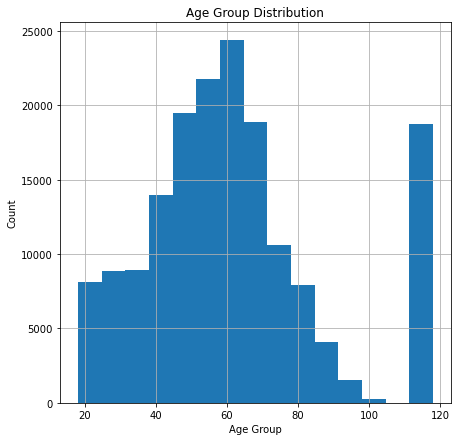

In [35]:
data.age.hist(figsize =(7,7), bins =15)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

In [36]:
indexAge = df[(df['age'] >= 100)].index
df.drop(indexAge , inplace=True)
df.head(15)

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5,"[web, email, mobile]",5,7,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5,"[web, email, mobile]",5,7,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5,"[web, email, mobile]",5,7,bogo
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,20180426,70000.0,5,"[web, email, mobile]",5,7,bogo
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,20180426,70000.0,5,"[web, email, mobile]",5,7,bogo
5,e2127556f4f64592b11af22de27a7932,offer completed,522,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,20180426,70000.0,5,"[web, email, mobile]",5,7,bogo
8,389bc3fa690240e798340f5a15918d5c,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,65,20180209,53000.0,5,"[web, email, mobile]",5,7,bogo
9,389bc3fa690240e798340f5a15918d5c,offer viewed,192,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,65,20180209,53000.0,5,"[web, email, mobile]",5,7,bogo
10,389bc3fa690240e798340f5a15918d5c,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,65,20180209,53000.0,5,"[web, email, mobile]",5,7,bogo
11,389bc3fa690240e798340f5a15918d5c,offer viewed,438,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,65,20180209,53000.0,5,"[web, email, mobile]",5,7,bogo


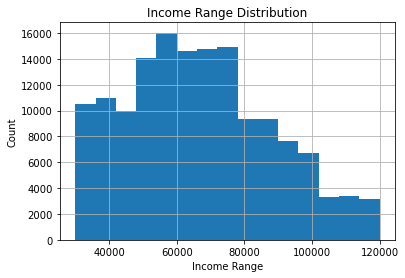

In [37]:
data.income.hist(bins = 15);
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

In [38]:
data.gender.value_counts()

M    82896
F    63719
O     2190
Name: gender, dtype: int64

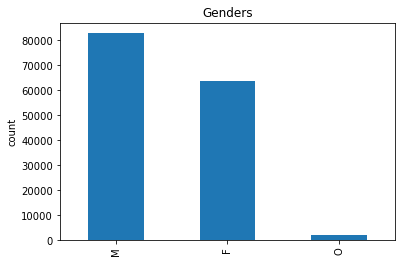

In [39]:
ax = data.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('count')
plt.title('Genders');

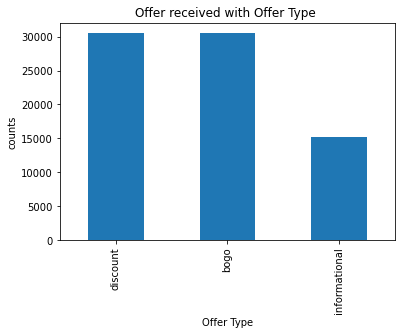

In [40]:
offer_received = data[data['event'] == 'offer received'].offer_type.value_counts()
offer_received.plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

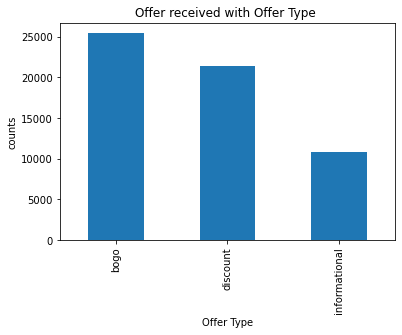

In [41]:
offer_received = data[data['event'] == 'offer viewed'].offer_type.value_counts()
offer_received.plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

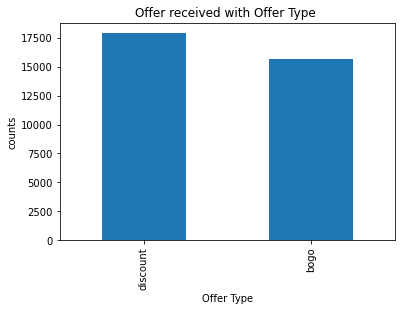

In [42]:
offer_received = data[data['event'] == 'offer completed'].offer_type.value_counts()
offer_received.plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

In [43]:
data.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'channels', 'difficulty',
       'duration', 'offer_type'],
      dtype='object')

In [44]:
data.head()

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5,"['web', 'email', 'mobile']",5,7,bogo
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,20180426,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,20180426,70000.0,5,"['web', 'email', 'mobile']",5,7,bogo


# Data preporcessing

In [45]:
data['year'] = df['became_member_on'].apply(lambda mytime: int(str(mytime)[0:4]))
data['day'] = df['became_member_on'].apply(lambda mytime: int(str(mytime)[4:6]))
data['month'] = df['became_member_on'].apply(lambda mytime: int(str(mytime)[6:8]))

data[['became_member_on','year','month','day']].head()

,became_member_on,year,month,day
0,20170509,2017.0,9.0,5.0
1,20170509,2017.0,9.0,5.0
2,20170509,2017.0,9.0,5.0
3,20180426,2018.0,26.0,4.0
4,20180426,2018.0,26.0,4.0


In [46]:
dummy = pd.get_dummies(data['gender'],prefix='gender')
data = pd.concat([df, dummy], axis=1 )

data[['gender', 'gender_M', 'gender_O', 'gender_F']].head()

,gender,gender_M,gender_O,gender_F
0,F,0,0,1
1,F,0,0,1
2,F,0,0,1
3,M,1,0,0
4,M,1,0,0


In [47]:
dummy = pd.get_dummies(data['offer_type'],prefix='offer_type')
data = pd.concat([df, dummy], axis=1 )
data[['offer_type', 'offer_type_bogo', 'offer_type_discount', 'offer_type_informational']].head()

,offer_type,offer_type_bogo,offer_type_discount,offer_type_informational
0,bogo,1,0,0
1,bogo,1,0,0
2,bogo,1,0,0
3,bogo,1,0,0
4,bogo,1,0,0


In [48]:
dummy = pd.get_dummies(data['offer_id'],prefix='offer_id')
data = pd.concat([data, dummy], axis=1 )
data.head()

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income,reward,...,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_3f207df678b143eea3cee63160fa8bed,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_5a8bc65990b245e5a138643cd4eb9837,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,20170509.0,100000.0,5.0,...,0,0,0,0,0,0,1,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,20170509.0,100000.0,5.0,...,0,0,0,0,0,0,1,0,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,20170509.0,100000.0,5.0,...,0,0,0,0,0,0,1,0,0,0
3,e2127556f4f64592b11af22de27a7932,offer received,408.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68.0,20180426.0,70000.0,5.0,...,0,0,0,0,0,0,1,0,0,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68.0,20180426.0,70000.0,5.0,...,0,0,0,0,0,0,1,0,0,0


In [49]:
dummy = pd.get_dummies(data['event'])
data = pd.concat([data, dummy], axis=1 )
data[['event', 'offer completed','offer received', 'offer viewed']].head()

,event,offer completed,offer received,offer viewed
0,offer received,0,1,0
1,offer viewed,0,0,1
2,offer completed,1,0,0
3,offer received,0,1,0
4,offer viewed,0,0,1


In [50]:
dummy = pd.get_dummies(data.channels.apply(pd.Series).stack()).sum(level=0)
data = pd.concat([data, dummy], axis=1)
data = data.drop(columns='channels')
data[['email', 'mobile', 'social', 'web']].head()

/tmp/ipykernel_27887/3169838132.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummy = pd.get_dummies(data.channels.apply(pd.Series).stack()).sum(level=0)


,email,mobile,social,web
0,1.0,1.0,0.0,1.0
1,1.0,1.0,0.0,1.0
2,1.0,1.0,0.0,1.0
3,1.0,1.0,0.0,1.0
4,1.0,1.0,0.0,1.0


In [51]:
data.head()

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income,reward,...,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,offer completed,offer received,offer viewed,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,20170509.0,100000.0,5.0,...,0,0,0,0,1,0,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,20170509.0,100000.0,5.0,...,0,0,0,0,0,1,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,20170509.0,100000.0,5.0,...,0,0,0,1,0,0,1.0,1.0,0.0,1.0
3,e2127556f4f64592b11af22de27a7932,offer received,408.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68.0,20180426.0,70000.0,5.0,...,0,0,0,0,1,0,1.0,1.0,0.0,1.0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68.0,20180426.0,70000.0,5.0,...,0,0,0,0,0,1,1.0,1.0,0.0,1.0


# handeling nulls

In [52]:
data.isnull().sum()

customer_id                                   18953
event                                         18953
time                                          18953
offer_id                                      18953
amount                                       167581
gender                                        18953
age                                           18953
became_member_on                              18953
income                                        18953
reward                                        18953
difficulty                                    18953
duration                                      18953
offer_type                                    18953
offer_type_bogo                                   0
offer_type_discount                               0
offer_type_informational                          0
offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7         0
offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2         0
offer_id_2906b810c7d4411798c6938adc9daaa5         0
offer_id_3f2

In [53]:
data = data.drop(columns=['amount'])

In [54]:
data.isnull().sum()

customer_id                                  18953
event                                        18953
time                                         18953
offer_id                                     18953
gender                                       18953
age                                          18953
became_member_on                             18953
income                                       18953
reward                                       18953
difficulty                                   18953
duration                                     18953
offer_type                                   18953
offer_type_bogo                                  0
offer_type_discount                              0
offer_type_informational                         0
offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7        0
offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2        0
offer_id_2906b810c7d4411798c6938adc9daaa5        0
offer_id_3f207df678b143eea3cee63160fa8bed        0
offer_id_4d5c57ea9a6940dd891ad5

In [55]:
data = data.dropna()
data.isnull().sum()

customer_id                                  0
event                                        0
time                                         0
offer_id                                     0
gender                                       0
age                                          0
became_member_on                             0
income                                       0
reward                                       0
difficulty                                   0
duration                                     0
offer_type                                   0
offer_type_bogo                              0
offer_type_discount                          0
offer_type_informational                     0
offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7    0
offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2    0
offer_id_2906b810c7d4411798c6938adc9daaa5    0
offer_id_3f207df678b143eea3cee63160fa8bed    0
offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0    0
offer_id_5a8bc65990b245e5a138643cd4eb9837    0
offer_id_9b98

In [56]:
data.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer_id_2906b810c7d4411798c6938adc9daaa5',
       'offer_id_3f207df678b143eea3cee63160fa8bed',
       'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer_id_5a8bc65990b245e5a138643cd4eb9837',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_f19421c1d4aa40978ebb69ca19b0e20d',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4', 'offer completed',
       'offer received', 'offer viewed', 'email', 'mobile', 'social', 'web'],
      dtype='object')

In [57]:
data

,customer_id,event,time,offer_id,gender,age,became_member_on,income,reward,difficulty,...,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,offer completed,offer received,offer viewed,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,20170509.0,100000.0,5.0,5.0,...,0,0,0,0,1,0,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,20170509.0,100000.0,5.0,5.0,...,0,0,0,0,0,1,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,20170509.0,100000.0,5.0,5.0,...,0,0,0,1,0,0,1.0,1.0,0.0,1.0
3,e2127556f4f64592b11af22de27a7932,offer received,408.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68.0,20180426.0,70000.0,5.0,5.0,...,0,0,0,0,1,0,1.0,1.0,0.0,1.0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68.0,20180426.0,70000.0,5.0,5.0,...,0,0,0,0,0,1,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,25d81869d43045c09ebf32a6696908e6,offer received,408.0,2298d6c36e964ae4a3e7e9706d1fb8c2,M,75.0,20170529.0,116000.0,3.0,7.0,...,0,0,0,0,1,0,1.0,1.0,1.0,1.0
167577,25d81869d43045c09ebf32a6696908e6,offer viewed,408.0,2298d6c36e964ae4a3e7e9706d1fb8c2,M,75.0,20170529.0,116000.0,3.0,7.0,...,0,0,0,0,0,1,1.0,1.0,1.0,1.0
167578,fc966e9c3edc4578a1fb4c6a8c2659c2,offer received,576.0,2298d6c36e964ae4a3e7e9706d1fb8c2,F,60.0,20160721.0,94000.0,3.0,7.0,...,0,0,0,0,1,0,1.0,1.0,1.0,1.0
167579,fc966e9c3edc4578a1fb4c6a8c2659c2,offer viewed,594.0,2298d6c36e964ae4a3e7e9706d1fb8c2,F,60.0,20160721.0,94000.0,3.0,7.0,...,0,0,0,0,0,1,1.0,1.0,1.0,1.0


# Data Modeling 

In [58]:
X = data.drop(['customer_id' , 'event' ,'offer completed', 'offer received',
       'offer viewed', 'offer_id', 'became_member_on', 'gender','offer_type'], axis=1)
Y = data['offer completed']

In [59]:
X.head()

,time,age,income,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,...,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_5a8bc65990b245e5a138643cd4eb9837,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,email,mobile,social,web
0,0.0,75.0,100000.0,5.0,5.0,7.0,1,0,0,0,...,0,0,1,0,0,0,1.0,1.0,0.0,1.0
1,6.0,75.0,100000.0,5.0,5.0,7.0,1,0,0,0,...,0,0,1,0,0,0,1.0,1.0,0.0,1.0
2,132.0,75.0,100000.0,5.0,5.0,7.0,1,0,0,0,...,0,0,1,0,0,0,1.0,1.0,0.0,1.0
3,408.0,68.0,70000.0,5.0,5.0,7.0,1,0,0,0,...,0,0,1,0,0,0,1.0,1.0,0.0,1.0
4,420.0,68.0,70000.0,5.0,5.0,7.0,1,0,0,0,...,0,0,1,0,0,0,1.0,1.0,0.0,1.0


### split the data to Training and Testing then save them for and further needs

In [60]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.125, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

train_data = X_train.copy()
train_data['offer_completed'] = y_train

test_data = X_test.copy()
test_data['offer_completed'] = y_test

train_data.to_csv('data/train.csv', index=False)
test_data.to_csv('data/test.csv', index=False)

(130049, 23) (18579, 23) (130049,) (18579,)


### training and testing data reading from the saved CSV files

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


X_train = pd.read_csv('data/train.csv').drop(columns=['offer_completed'])
X_test = pd.read_csv('data/test.csv').drop(columns=['offer_completed'])
y_train = pd.read_csv('data/train.csv')['offer_completed']
y_test = pd.read_csv('data/test.csv')['offer_completed']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(130049, 23) (18579, 23) (130049,) (18579,)


## Data scaling 

In [62]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

### First model : SGD Classifier

In [63]:
param_grid = dict(penalty=['l2', 'l1','elasticnet'], 
                         alpha=[0.1, 0.01, 0.001, 0.0001],
                        loss = ['squared_error','hinge'])

clf_SGD = GridSearchCV(estimator=SGDClassifier(), param_grid= param_grid)
clf_SGD.fit(X_train, y_train)

print("training Accuracy: ", clf_SGD.score(X_train,y_train))
print("testing Accuracy: ", clf_SGD.score(X_test,y_test))
print(clf_SGD.best_params_)

training Accuracy:  0.7819360394928065
testing Accuracy:  0.7825501910759459
{'alpha': 0.001, 'loss': 'squared_error', 'penalty': 'l1'}


### 2nd model : Naive Bayes classifier (gaussian Naive bayes )

In [64]:
param_grid= {
    'var_smoothing': np.logspace(0,-9, num=100)
}

clf_NB = GridSearchCV(estimator=GaussianNB(),param_grid= param_grid)
clf_NB.fit(X_train, y_train)

print("traning Accuracy: ", clf_NB.score(X_train,y_train))
print("testing Accuracy: ", clf_NB.score(X_test,y_test))
print("best parameters: ", clf_NB.best_params_)

traning Accuracy:  0.5612653692069912
testing Accuracy:  0.559395015878142
best parameters:  {'var_smoothing': 1.0}


### 3rd model: Random forest Classifier

In [65]:
param_grid = {"max_depth": [3,6, None], "min_samples_split": [3, 5, 10, 15]}
clf_RF = GridSearchCV(estimator=RandomForestClassifier(),param_grid= param_grid)
clf_RF.fit(X_train, y_train)

print("traning Accuracy: ", clf_RF.score(X_train,y_train))
print("testing Accuracy: ", clf_RF.score(X_test,y_test))
print("best parameters: ", clf_RF.best_params_)

traning Accuracy:  0.7957692869610685
testing Accuracy:  0.7950374078260402
best parameters:  {'max_depth': 6, 'min_samples_split': 5}


### compare between their accuracy on the training data 

{'SGD Classifier': 0.7819360394928065, 'Naive Bayes Classifier': 0.5612653692069912, 'Random forest Classifier': 0.7957692869610685}


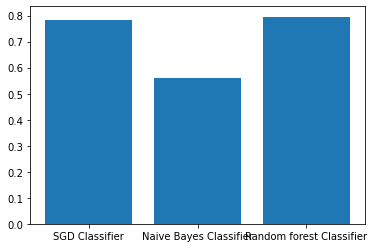

In [66]:
acc_on_training = {}
acc_on_training['SGD Classifier'] = clf_SGD.score(X_train,y_train)
acc_on_training['Naive Bayes Classifier'] = clf_NB.score(X_train,y_train)
acc_on_training['Random forest Classifier'] = clf_RF.score(X_train,y_train)

print(acc_on_training)

plt.bar(range(len(acc_on_training)), list(acc_on_training.values()), tick_label=list(acc_on_training.keys()))
plt.show()

### compare between their accuracy on the testing data 

{'SGD Classifier': 0.7825501910759459, 'Naive Bayes Classifier': 0.559395015878142, 'Random forest Classifier': 0.7950374078260402}


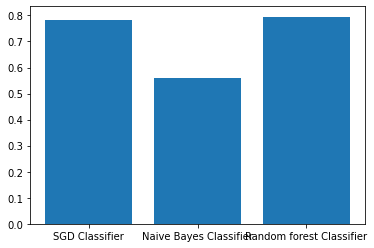

In [67]:
acc_on_testing = {}
acc_on_testing['SGD Classifier'] = clf_SGD.score(X_test,y_test)
acc_on_testing['Naive Bayes Classifier'] = clf_NB.score(X_test,y_test)
acc_on_testing['Random forest Classifier'] = clf_RF.score(X_test,y_test)

print(acc_on_testing)

plt.bar(range(len(acc_on_testing)), list(acc_on_testing.values()), tick_label=list(acc_on_testing.keys()))
plt.show()

### observation: Random forest classifiers got the highest accuracy so i will choose the it to be deployed